## Init & utils

In [ ]:
%%bash
# tar -cvzf pr_4.tgz pr | wc -l
# tar -cvzf pr_tables.tgz pr_tables*.json
# tar -xvzf pr_tables.tgz
# tar -xvzf pr_4.tgz | wc -l
ls pr | wc -l

In [ ]:
from jsonpath_rw import jsonpath, parse
import jsonpath_rw_ext as jsonp
import collections
import os
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
import json 
from json import JSONEncoder, JSONDecoder
import pickle

class PythonObjectEncoder(JSONEncoder):
    def default(self, obj):
        if isinstance(obj, (list, dict, str, unicode, int, float, bool, type(None))):
            return JSONEncoder.default(self, obj)
        return {'_python_object': pickle.dumps(obj)}

def as_python_object(dct):
    if '_python_object' in dct:
        return pickle.loads(str(dct['_python_object']))
    return dct

def save_to_json_file(filename, content):
    temp = json.dumps(content, cls=PythonObjectEncoder)
    return save_to_file(filename, temp)

def save_to_file(filename, content):
    with open(filename, 'w') as file:
        file.write(content)
    return "saved " + filename    

def load_from_json_file(file_name):
    content = load_from_file(file_name)
    return json.load(content, object_hook=as_python_object)

def load_from_file(file_name):
    return open(file_name)

In [ ]:
import copy

def inc_dict_val(d, k, v):
    d[k] = int(d.get(k, 0)) + int(v)

def alter_dict(D, **F):
    result = copy.deepcopy(D)    
    result.update(**F)
    return result   

def map_dict(src, *args, **kvargs):
    dst = dict()
    for v in args:
        dst[v] = src[v]
    for k,v in kvargs.items():
        dst[k] = src[v]
    return dst

def remove_from_dict(d, key):
    if key in d:
        del d[key]

## Printing

In [ ]:
from pprint import pprint
from IPython.display import JSON

width = 180
def print_line(char=' '):
    print(char*width)

In [ ]:
import re

def print_log(log, consumer=print, **args):
    if log:
        params = {g:'' for g in re.findall('\$\{([^}]+)\}', log)}
        params.update(args)
        consumer(log.replace('$', '').format(**params))

In [ ]:
from jsondiff import diff

def print_diff(old_dict, new_dict, consumer=print):     
    consumer(get_diff(old_dict, new_dict))
    
def get_diff(old_dict, new_dict):     
    return diff(old_dict, new_dict, syntax='symmetric')

In [ ]:
points = [1, 5, 20, 100, 500, 1000]

import sys
import time

def print_progress(i, timer_log=None, total=None):
    if (i % points[0] == 0):
        if i > 0 and (i % points[1] == 0):
            sys.stdout.write(' ')
            if (i % points[2] == 0):
                sys.stdout.write('  ')
                if (i % points[3] == 0):
                    sys.stdout.write('\n')
                    if (i % points[4] == 0):
                        sys.stdout.write('\n')
                        if total and (i % points[5] == 0):                            
                            timer_log = print_stats(total, i, points[5], timer_log)
        sys.stdout.write('.')
        sys.stdout.flush()   
        
def print_stats(total, processed, bunch, last_time, **kwargs):
    now = time.time()
    speed = (now-last_time)/60.0/bunch
    eta = speed*(total-processed)
    print('speed: {speed:.1f} min/bunch, eta: {eta:.2f} min\n'.format(speed = speed, eta = eta, **kwargs))
    return now

def with_progress(l, size=None):
    for i,v in enumerate(l):
        print_progress(i, time.time(), size)
        yield v

In [ ]:
from IPython.display import display_html
def display_side_by_side(*args):
    html_str=''
    for df in args:
        html_str+=df.to_html()
    display_html(html_str.replace('table','table style="display:inline; padding-right: 100px;"'),raw=True)

## Analitical fn

In [ ]:
def collect_data(files, collector):
    for f in files:
        data = load_from_json_file(f)
        yield collector(data)

def flattern(data):
    return [l2 for l1 in data for l2 in l1]

def get_nodes(data, ptr):
    return [match.value for match in jsonp.parse(ptr).find(data)]

In [ ]:
def select_all(key):
    return lambda data: jsonp.match(key, data)

def select_one(key):
    return lambda data: jsonp.match1(key, data)

def contains(key, value):
    return lambda data: jsonp.match1(key, data) == value

def all_of(*filters):
    def fn(data):
        for f in filters:
            if not f(data):
                return False
        return True  
    return fn

In [ ]:
def for_each(data, *funs):
    for fun in funs:
        data = fun(data)
    return data

## Analysis

In [ ]:
from os import listdir
from os.path import isfile, join

game = 'pr'
games = [join(game, f) for f in listdir(game) if f.endswith('.json')]
len(games)

In [ ]:
games.sort()
datas = [load_from_json_file(f) for f in with_progress(games[(len(games) % 100):])]


# ACTIVE DEVELOPMENT ZONE


In [ ]:
def steps(log):
    for move_id, move in enumerate(log):
        for sub_move_id, sub_move in enumerate(move['data']):
            yield sub_move

In [ ]:
stats = for_each(datas, select_all('$..data[?(@.type == "gameStateChange" & @.args.action == "stGameEnd")].args.args'))

In [ ]:
game_log = datas[1]['log']['data']['data']['data']
res = game_log[-1]['data'][-2]['args']['args']
JSON(res, width=width)

In [ ]:
d = [p['result'][0]['stats']['10'] for p in stats]

<module 'matplotlib.pyplot' from '/srv/conda/lib/python3.6/site-packages/matplotlib/pyplot.py'>

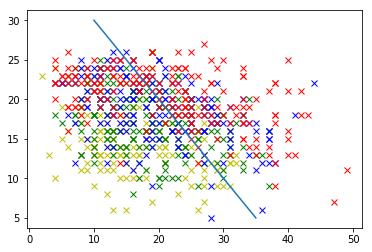

<Figure size 720x720 with 0 Axes>

In [79]:
br = 40
plt.plot(
    [int(p['result'][3]['stats']['10']) for p in stats], [int(p['result'][3]['stats']['11']) for p in stats], 'yx',
    [int(p['result'][2]['stats']['10']) for p in stats], [int(p['result'][2]['stats']['11']) for p in stats], 'gx',
    [int(p['result'][1]['stats']['10']) for p in stats], [int(p['result'][1]['stats']['11']) for p in stats], 'bx',
    [int(p['result'][0]['stats']['10']) for p in stats], [int(p['result'][0]['stats']['11']) for p in stats], 'rx',
    [br-5, br-30], [5, 30]
)
# plt.axis([0, 52,0, 30])
plt.figure(figsize=(10,10))
plt

<BarContainer object of 33 artists>

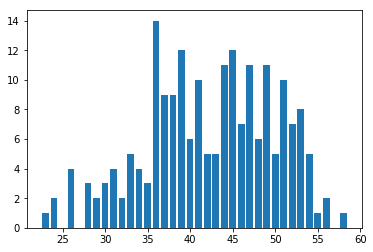

In [97]:
avg = [int(p['table']['stats']['2']) for p in stats]
count = collections.Counter(avg)
plt.bar([x for x in count.keys()], [x for x in count.values()])

In [69]:
table_stats = {
     '1': '_',
     '4': 'Game duration',
     '3': 'Players average level',
     '2': 'Average score',
    '10': 'Unclaimed victory points',
    '11': 'Unclaimed colonists',
    '12': 'Doubloons in the bank',
    '13': 'Unclaimed plantations',
    '14': 'Unclaimed quarries',
    '15': 'Unclaimed small buildings',
    '16': 'Unclaimed large buildings'}

player_stats = {
     '1': 'Thinking time',
    '10': 'VPs earned by shipping',
    '11': 'VPs earned by building',
    '12': 'VPs earned from large buildings',
    '13': 'Doubloons owned at game end',
    '14': 'Good barrels owned at game end',
    '15': 'Colonists',
    '16': 'Plantations',
    '17': 'Quarries',
    '18': 'Small buildings',
    '19': 'Large buildings'}

tdf = pd.DataFrame([table_stats, res['table']['stats']]).T
pdf = pd.DataFrame(
    data  = [player_stats] + [x['stats']  for x in res['result']], 
    index =       ['name'] + [x['player'] for x in res['result']]
).T

display_side_by_side(pdf, tdf)

,name,83864705,83914097,1019711,84006291
1,Thinking time,20216.4,22930,13674.8,29593.3
10,VPs earned by shipping,33,37,18,19
11,VPs earned by building,20,16,19,17
12,VPs earned from large buildings,8,6,12,7
13,Doubloons owned at game end,2,3,4,3
14,Good barrels owned at game end,5,1,1,0
15,Colonists,15,15,16,15
16,Plantations,9,9,7,11
17,Quarries,1,1,3,1
18,Small buildings,7,6,6,6


In [ ]:
group = ['scoreShippingPoints', 'scoreConditionalPoints', 'scoreEndPoints', 'buildingBought']
selected = [s for s in steps(game_log) if s['type'] in group]
argsByType = lambda t: [s['args'] for s in selected if s['type'] == t]

buildings = {s['bld_id']: {
    'player_id': s['player_id'], 
    'building': s['bld_type_tr'],
    'score': int(s['score_delta'])
} for s in argsByType('buildingBought')}

buildings_score = {}
for b in buildings.values():
    buildings_score.setdefault(b['player_id'], 0)
    buildings_score[b['player_id']] += b['score']

JSON({
    'shipping'   : {s['player_id']: int(s['score_delta']) for s in argsByType('scoreShippingPoints')},
    'conditional': {s['building_name']: {
        s['player_id']: int(s['score_delta'])
    } for s in argsByType('scoreConditionalPoints')},
    'endScore'   : {s['player_id']: int(s['score_delta']) for s in argsByType('scoreEndPoints')},
    'buildings_s': buildings_score,
    'buildings'  : buildings
}, width=width)

In [ ]:
flat = [s for s in steps(game_log) if s['type'] not in ['gameStateChange', 'message', 'updateReflexionTime']]
c = collections.Counter([s['type'] for s in flat])
c.most_common(20)

In [ ]:
# pprint(stats[7], width=width)

## Generic bga functions

In [ ]:
def load_game(fn):
    return load_from_json_file(fn)['data']['data']['data']

def get_step(game, move_id=0, sub_move_id=0, **kvargs):
    return game[move_id]['data'][sub_move_id]

def move_to_next_step(game, game_state):
    move_id     = game_state.get('move_id', 0)
    sub_move_id = game_state.get('sub_move_id', 0) + 1
    
    if len(game[move_id]['data']) <= sub_move_id:
        move_id    += 1
        sub_move_id = 0
    
    return alter_dict(game_state,
        move_id     = move_id,
        sub_move_id = sub_move_id
    )

def default_action(game_state, step):
    print("Unknown action '%s' :(" % step['type'])
    display(JSON({'state': game_state, 'step': step}, indent=4))
    return None

def apply_step(game_state, step):
    if not step['args']: 
        step['args'] = dict()
    elif not isinstance(step['args'], dict): 
        step['args'] = {str(i):v for i,v in enumerate(step['args'])}
        
    if step['log']:
        print_log('[{step_type}] ' + step['log'], step_type=step['type'], **step['args'])
        
    a = actions.get(step['type'], None)
    if a:
        return a(game_state, **step['args'])
    else:
        return default_action(game_state, step)        

def debug(state, step, fn=None):
    if not fn:
        fn = globals()[step['type']]
    display(
        JSON(state, root='state'), 
        JSON(step, root='step'), 
    )
    new_state = fn(state, **step['args'])
    pprint(get_diff(state, new_state), width=10)

## Puerto rico functions

## initialization

In [ ]:
good_types = ['corn', 'indigo', 'sugar', 'tobacco', 'coffee']

def setup_buildings(buildings, **kvargs):
    result = {}
    def inc(d, k): d[k] = 1 + d.get(k, 0) 
    for b in buildings.values():
        inc(result, b['bld_type'])
    return result

def setup_plantations(plantations_to_set, **kvargs):
    result = [p['res_type'] for p in plantations_to_set.values()]
    return result

def setup_ships(ships, **kvargs): 
    result = {v['shp_id']:{
        'capacity': int(v['shp_capacity']),
        'goods': 0,
        'res_type': None
    } for v in ships.values()}
    return result

def setup_stock(**kvargs):
    result = []
    return result

def setup_VPs(counters, **kvargs): 
    return int(counters['shipping_points_bank']['counter_value'])

def setup_bank(counters, **kvargs): 
    return int(counters['doubloons_bank']['counter_value'])

def setup_workers(counters, **kvargs): 
    result = {
        'available': int(counters['colonists_bank']['counter_value']),
        'arriving':  int(counters['colonists_ship']['counter_value'])
    }
    return result

def setup_goods(counters, **kvargs): 
    result = {
        'coffee'  : int(counters['resource_coffee_bank']['counter_value']),
        'corn'    : int(counters['resource_corn_bank']['counter_value']),
        'indigo'  : int(counters['resource_indigo_bank']['counter_value']),
        'sugar'   : int(counters['resource_sugar_bank']['counter_value']),
        'tobacco' : int(counters['resource_tobacco_bank']['counter_value']),
    }
    return result

def setup_roles(role_tooltips, **kvargs):
    result = {v['rol_id']:{
        'money': int(v['money']), 
        'rol_type': v['rol_type'], 
        'selected': False
    } for v in role_tooltips.values()}
    return result
    
def setup_playerorder(playerorder, **kvargs):
    result = [str(v) for v in playerorder]
    return result

def setup_player(index, username, money, plantaion, **kvargs):
    result = {
        '_': username,
        'money': int(money),
        'building_vp': 0,
        'delivery_vp': 0,
        'buildings': {'commercial': {}, 'factories': {g:{'jobs':0, 'workers':0} for g in good_types}},
        'goods': {g:0 for g in good_types},
        'plantations': {g:{'jobs':1 if g == plantaion else 0, 'workers':0}  for g in (good_types + ['rock'])},
        'potential_vp': {'commercial': 0, 'factories': 0, 'workers': 0},
        'slots': {'buildings': 12, 'plantations': 11},
        'workers': {'total': 0, 'unemployed': 0}
    }
    result['goods']['stored'] = {}
    return result

def setup_players(players, playerorder, counters, plantations_owned, **kvargs):
    result = {}
    for index,id in enumerate(playerorder):
        id = str(id)
        money = counters['doubloons_player_'+id]['counter_value']
        plantation = [v['res_type'] for k,v in plantations_owned.items() if v['player_id'] == id][0]
        result[id] = setup_player(index, players[id]['name'], money, plantation)
    return result

def setup_table(datas):
    r = {
        'buildings': setup_buildings(**datas),
        'plantations': setup_plantations(**datas),
        'ships': setup_ships(**datas),
        'stock': setup_stock(**datas),
        'VPs': setup_VPs(**datas),
        'money': setup_bank(**datas),
        'workers': setup_workers(**datas),
        'goods': setup_goods(**datas),
        'roles': setup_roles(**datas),
        'playerorder': setup_playerorder(**datas)
    }
    return r

def setup(datas):
    return {
        'move_id': 0,
        'sub_move_id': 0,
        'table': setup_table(datas),
        'players': setup_players(**datas),
        'governor': datas['governor']
    }

In [ ]:
def setup_lookups(buildings, plantations_owned, **kvargs):
    global building_lookup
    building_lookup = {k:{
        'name': b['bld_type'],
        'type': 'factories' if b['res_type'] else 'commercial',
        'res_type': b['res_type'],
        'potential_vp': 1 if b['bld_valence'] == "1" else 2,
        'tile_size': 2 if b['bld_max_discount'] == "4" else 1,
        'jobs': int(b['bld_valence']),
        'cost': int(b['bld_cost']),
        'max_discount': int(b['bld_max_discount']),
        'vp': int(b['bld_score'])
    } for k,b in buildings.items()}
    
    global plantation_lookup
    plantation_lookup = {k:p['res_type'] for k,p in plantations_owned.items()}
    
    global colonist_lookup
    colonist_lookup = {}    
    
    global run_limits
    run_limits = {}   

In [ ]:
new_game_state = 1
if not 'actions' in globals():
    global actions
    actions = dict()    

game_log = load_game('table_27174212.json')
datas = load_from_json_file('datas_27174212.json')[7]
game_state = setup(datas)
setup_lookups(**datas)

### Game actions

In [ ]:
def get_player(state, player_id=None, **args):
    return state['players'].get(str(player_id), None)

def prepare(state, **kvargs):
    new_state = alter_dict(state)
    player = get_player(new_state, **kvargs)
    table = new_state['table']
    return new_state, player, table

In [ ]:
def do_nothing(log=None):
    def dn(state, **args):
        print_log(log, **args)
        return state
    return dn
log = ' - d:${description:70} t:${type}, n:${name}'#', a:${action}'#', possible_actions:${possibleactions}'

actions['leaveGameState']      = do_nothing('<-[leaveGameState ]' + log)
actions['gameStateChange']     = do_nothing('->[gameStateChange]' + log)
actions['updateReflexionTime'] = do_nothing('  [updateReflexionTime]')
actions['message' ]            = do_nothing()
actions['gameStateMultipleActiveUpdate'] = do_nothing('  gameStateMultipleActiveUpdate')

def roleSelected(state, rol_id, rol_type, unavailable_roles, **args):
    new_state = alter_dict(state)
    r = new_state['table']['roles'][rol_id]
    new_state['table']['money'] += r['money']
    r['money'] = 0
    r['selected'] = True
    return new_state

actions['roleSelected'] = roleSelected

def plantationSettlement(state, player_id, **args):
    new_state = alter_dict(state)
    pl = get_player(new_state, player_id)
#     update_counter(new_state['table'], **args)
    pick_field(new_state['table'], pl, **args)
    return new_state

def pick_field(table, player, res_type, pla_id, **args):
    player['plantations'][res_type]['jobs'] += 1
    player['slots']['plantations'] -= 1
    if res_type in table['plantations']:
        table['plantations'].remove(res_type)
    plantation_lookup[pla_id] = res_type


def update_counter(target, counter_name=None, counter_delta=0, **args):
    if counter_name is not None:
        target[counter_name] += counter_delta

actions['plantationSettlement'] = plantationSettlement

def discardPlantations(state, **args):
    return state

actions['discardPlantations'] = discardPlantations

def drawPlantations(state, plantations_to_set, **args):
    new_state = alter_dict(state)
    new_state['table']['plantations'] = setup_plantations(plantations_to_set)
    return new_state

actions['drawPlantations'] = drawPlantations

def buildingBought(state, bld_type_tr, cost, **kvargs):
    new_state, p, t = prepare(state, **kvargs)
    cost = int(cost)
        
    add_building_to_player(p, bld_type_tr, **kvargs)
    t['buildings'][bld_type_tr] -= 1
    
    p['money'] -= cost
    t['money'] += cost
    return new_state

def add_building_to_player(player, bld_type_tr, score_delta, bld_id, **kvargs):
    b = building_lookup[bld_id]
    player['slots']['buildings'] -= b['tile_size']
    player['building_vp'] += int(score_delta)
    player['potential_vp'][b['type']] += b['potential_vp']
    if b['type'] == 'commercial':
        player['buildings']['commercial'][b['name']] = False  
    else:
        player['buildings']['factories'][b['res_type']]['jobs'] += b['jobs']
    
actions['buildingBought'] = buildingBought

def colonistsEarnedFromShip(state, delta, **kvargs):
    new_state, p, t = prepare(state, **kvargs)

    p['workers']['total'] += delta
    p['workers']['unemployed'] += delta
    t['workers']['arriving'] -= delta
  
    return new_state

def colonistsEarnedFromSupply(state, delta, **kvargs):
    new_state, p, t = prepare(state, **kvargs)
    
    p['workers']['total'] += delta
    p['workers']['unemployed'] += delta
    t['workers']['available'] -= delta
    
    return new_state

actions['colonistsEarnedFromSupply'] = colonistsEarnedFromSupply
actions['colonistsEarnedFromShip'] = colonistsEarnedFromShip

def colonistToBuilding(state, col_id, bld_id, delta, **kvargs):
    new_state = alter_dict(state)
    colonist_lookup[col_id] = {'id': bld_id, 'type': 'bld'}
    b = building_lookup[bld_id]
    pl = get_player(new_state, **kvargs)
    pb = pl['buildings'][b['type']]

    if b['type'] != 'commercial':
        pb[b['res_type']]['workers'] += delta
    else:
        pb[b['name']] = True
    pl['workers']['unemployed'] -= delta
    return new_state

def colonistToPlantation(state, col_id, pla_id, delta, **kvargs):
    new_state = alter_dict(state)
    colonist_lookup[col_id] = {'id': pla_id, 'type': 'pla'}
    p = get_player(new_state, **kvargs)
    res_type = plantation_lookup[pla_id]
    
    p['plantations'][res_type]['workers'] += delta
    p['workers']['unemployed'] -= delta
    return new_state

def colonistToSanJuan(state, col_id, delta, **kvargs):
    id = colonist_lookup[col_id]['id']
    type = colonist_lookup[col_id]['type']
    if type == 'pla':
        state = colonistToPlantation(state, col_id, id, -delta, **kvargs)
    else:
        state = colonistToBuilding(state, col_id, id, -delta, **kvargs)
    return state
    
actions['colonistToBuilding'] = colonistToBuilding
actions['colonistToPlantation'] = colonistToPlantation
actions['colonistToSanJuan'] = colonistToSanJuan

def colonistsToShip(state, delta, **kvargs):
    new_state = alter_dict(state)
    delta = int(delta)
    new_state['table']['workers']['available'] -= delta
    new_state['table']['workers']['arriving']  += delta
    return new_state

actions['colonistsToShip'] = colonistsToShip

def produceGoods(state, res_type, delta, **kvargs):
    new_state, p, t = prepare(state, **kvargs)    
    delta = int(delta)    
    t['goods'][res_type] -= delta
    p['goods'][res_type] += delta
    return new_state

actions['produceGoods'] = produceGoods

def doubloonsEarned(state, delta, **kvargs):
    new_state, p, t = prepare(state, **kvargs) 
    delta = int(delta)
    t['money'] -= delta
    p['money'] += delta
    return new_state

actions['doubloonsEarned'] = doubloonsEarned

def doubloonToRole(state, **kvargs):
    new_state, p, t = prepare(state, **kvargs)
    rol_id = dict(kvargs['role_tooltips']).popitem()[0]
    t['money'] -= 1
    t['roles'][rol_id]['money'] += 1
    return new_state

actions['doubloonToRole'] = doubloonToRole

def newGovernor(state, new_governor_player_id, **kvargs):
    new_state = alter_dict(state)
    new_state['governor'] = new_governor_player_id
    for r in new_state['table']['roles'].values():
        r['selected'] = False
    return new_state

actions['newGovernor'] = newGovernor

def goodsShipped(state, shp_id, res_type, delta, **kvargs):
    new_state, p, t = prepare(state, **kvargs)
    
    if shp_id:
        t['ships'][shp_id]['res_type'] = res_type
        t['ships'][shp_id]['goods'] += delta
        p['goods'][res_type] -= delta
    else:
        t['goods'][res_type] += delta
        p['goods'][res_type] -= delta

    return new_state

def victoryPointsEarned(state, delta, **kvargs):
    new_state, p, t = prepare(state, **kvargs)
    
    t['VPs'] -= delta
    p['delivery_vp'] += delta

    return new_state

  
actions['selectShip'] = do_nothing('selectShip')
actions['selectWharf'] = do_nothing('selectWharf')
actions['goodsShipped'] = goodsShipped
actions['victoryPointsEarned'] = victoryPointsEarned

def moveGoodsToSupply(state, **kvargs):
    new_state = alter_dict(state)
    
    for s in new_state['table']['ships'].values():
        if int(s['capacity']) <= s['goods']:
            new_state['table']['goods'][s['res_type']] += s['goods']
            s['goods'] = 0
            s['res_type'] = None
            
    if len(new_state['table']['stock']) == 4:
        for res_type in new_state['table']['stock']:
            new_state['table']['goods'][res_type] += 1
        new_state['table']['stock'] = []
            
    return new_state

actions['moveGoodsToSupply'] = moveGoodsToSupply

def check_limit(limit):
    if run_limits[limit] == 0:
        raise Exception('"{}" must be reviewed'.format(limit))
    else:
        run_limits[limit] -= 1

def goodStored(state, res_type, one_by_one, **kvargs):
    new_state, p, t = prepare(state, **kvargs)
    p['goods']['stored'][res_type] = {'one_by_one': one_by_one}
    return new_state

def goodUnstored(state, res_type, one_by_one, **kvargs):
    new_state, p, t = prepare(state, **kvargs)
       
    del p['goods']['stored'][res_type]
    return new_state

def endOfStorage(state, **kvargs):
    pprint(kvargs)
    return state

actions['goodStored'] = goodStored
actions['goodUnstored'] = goodUnstored
actions['endOfStorage'] = endOfStorage

def lostGoodsToSupply(state, **kvargs):
    new_state, p, t = prepare(state, **kvargs)
    for res_type in good_types:
        if res_type not in p['goods']['stored']:
            t['goods'][res_type] += p['goods'][res_type]
            p['goods'][res_type] = 0
        elif 'one_by_one' in p['goods']['stored'][res_type] and p['goods']['stored'][res_type]['one_by_one']:
            t['goods'][res_type] += p['goods'][res_type] - 1
            p['goods'][res_type] = 1
        
    p['goods']['stored'] = {}
            
    return new_state

actions['lostGoodsToSupply'] = lostGoodsToSupply

def resourceSold(state, res_type, **kvargs):
    new_state, p, t = prepare(state, **kvargs)
    
    p['goods'][res_type] -= 1
    t['stock'].append(res_type)
            
    return new_state

actions['resourceSold'] = resourceSold

actions['draftCompleted'] = do_nothing('draftCompleted')
actions['reshufflePlantations'] = do_nothing('reshufflePlantations')
actions['lastYear'] = do_nothing()
actions['scoreShippingPoints'] = do_nothing()
actions['scoreConditionalPoints'] = do_nothing()
actions['scoreEndPoints'] = do_nothing()
actions['endOfGame'] = do_nothing()
actions['simpleNode'] = do_nothing()

In [ ]:
# x = debug(game_state, next_step, lostGoodsToSupply)

In [ ]:
new_game_state = 1
while new_game_state and len(game_log) > game_state['move_id']:
        
    next_step = get_step(game_log, **game_state)
    if next_step['type'] not in ('gameStateChange', 'updateReflexionTime', 'message'):
        display(JSON(next_step, root='next_step'))
        print_line('.')
        print()
        
    new_game_state = apply_step(game_state, next_step)
    
    if new_game_state:
        if not game_state is new_game_state:
            print()    
            print_diff(game_state, new_game_state, consumer=lambda l: pprint(l, width=10))
            print_line('-')    
            
        game_state = move_to_next_step(game_log, new_game_state)
        if not game_state['sub_move_id']: 
            print()
            print_line('=')
            print('move {move_id}.{sub_move_id}'.format(**game_state))
            display(JSON(game_state, root='game_state'))
#             break          
            print_line('=')